https://www.youtube.com/watch?v=5_cJs9YOPw0

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

#plt.style.use("fivethirtyeight")

In [2]:
#Function to creat and get the Bollinger Bands
def bollinger_bands(data, window_size = 50):
    rolling_mean = data["Close"].rolling(window = window_size).mean() #Cette ligne calcule la moyenne mobile en utilisant la méthode rolling de Pandas sur la colonne "close" du DataFrame data. La méthode rolling(window=window_size) crée une fenêtre mobile de taille window_size, puis .mean() calcule la moyenne sur cette fenêtre mobile. Cela produit une série contenant la moyenne mobile pour chaque point de données.
    rolling_std = data['Close'].rolling(window=window_size).std() #Cette ligne calcule l'écart-type en utilisant une méthode similaire à celle utilisée pour calculer la moyenne mobile.
    data['UpperBand'] = rolling_mean + (2 * rolling_std) # Cette ligne calcule la limite supérieure des bandes de Bollinge
    data['LowerBand'] = rolling_mean - (2 * rolling_std) # Cette ligne calcule la limite inférieure des bandes de Bollinger 
    return data 

    Pour des données à plus long terme, telles que des données journalières, une fenêtre plus grande (par exemple, 20, 50 ou 100) peut être appropriée pour lisser les fluctuations de prix à court terme et identifier les tendances à plus long terme.

    Pour des données à court terme, telles que des données intraday ou à haute fréquence, une fenêtre plus petite (par exemple, 5, 10 ou 20) peut être plus appropriée pour capturer les variations de prix rapides et réagir rapidement aux changements du marché.

    Il est souvent utile de tester différentes valeurs de window_size pour trouver celle qui fonctionne le mieux pour un marché spécifique ou une stratégie de trading particulière. Les traders peuvent ajuster cette valeur en fonction de leur expérience et de leurs préférences personnelles, ainsi que des conditions de marché.

In [3]:
#Fonction to create and get the relative strength index (RSI)
def RSI(data, window=20):
    delta = data['Close'].diff() #calcule la différence entre les prix de clôture successifs en utilisant la méthode diff() de Pandas. Cela donne une série de variations de prix (delta).
    gain = delta.where(delta > 0,0) # crée une série gain qui contient les variations de prix positives (c'est-à-dire lorsque delta est supérieur à zéro) et remplace les autres valeurs par zéro. Cela signifie que gain contient les gains lorsque les prix augmentent.
    loss = delta.where(delta <0,0) #crée une série loss qui contient les variations de prix négatives (lorsque delta est inférieur à zéro) et remplace les autres valeurs par zéro. Cela signifie que loss contient les pertes lorsque les prix diminuent.
    avg_gain = gain.rolling(window).mean() # Cette ligne calcule la moyenne mobile des gains sur une fenêtre de window périodes en utilisant la méthode rolling().mean() de Pandas. Cela donne une moyenne mobile des variations de prix positives sur la période spécifiée.
    avg_loss = loss.rolling(window).mean() #Cette ligne calcule la moyenne mobile des pertes sur une fenêtre de window périodes, de manière similaire à la ligne précédente.
    RS = avg_gain / avg_loss #Cette ligne calcule le rapport de la moyenne mobile des gains sur la moyenne mobile des pertes. Cela donne le rapport de force (Relative Strength, RS).
    RSI = 100 - (100/(1+RS)) #Le RSI est une mesure normalisée de la force relative, et cette formule est utilisée pour la calculer.
    data['RSI'] = RSI
    data['Overbought'] = 70 
    data['Oversold'] = 30 
    return data

Pour le RSI, 

    Pour des périodes de trading plus courtes et une analyse plus réactive des mouvements de prix, vous pouvez réduire la fenêtre à environ 9 ou 10 périodes.

    Pour des périodes de trading plus longues et une analyse plus lisse des tendances, vous pouvez augmenter la fenêtre à 20 périodes ou plus.

    Il est également courant d'utiliser des valeurs plus petites pour la fenêtre lorsqu'on trade des actifs très volatils et des valeurs plus grandes pour des actifs moins volatils.

In [4]:
#Ddefine a function to create and get the trading strategy
#Buy when the close price goes below the Lower Band and the RSI is less than 30 
#Sell when the close price goes above the Upper Band and the RSI is greather than 60

def strategy(data):
    position = 0 
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['LowerBand'][i] and data['RSI'][i] < data['Oversold'][i] and position == 0:
            position = 1 
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)
        elif data['Close'][i] > data['UpperBand'][i] and data['RSI'][i] > data['Overbought'][i] and position == 1:
            position = 0 
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    return(buy_price,sell_price)

In [5]:
import yfinance as yf
import seaborn as sns
import datetime as dt

startdate = '2021-11-25'


#Get the stock data
action = "STM"
data = yf.download(action, start=startdate, end=dt.datetime.today().strftime('%Y-%m-%d'), progress=True)

[*********************100%%**********************]  1 of 1 completed


In [6]:
#add tje Bollinger Bands to the data set
data = bollinger_bands(data)

#Add the RSI to the data set
data = RSI(data)

In [7]:
#Implement the trading strategy 
buy_price, sell_price = strategy(data)
data['buy'] = buy_price
data["sell"] = sell_price

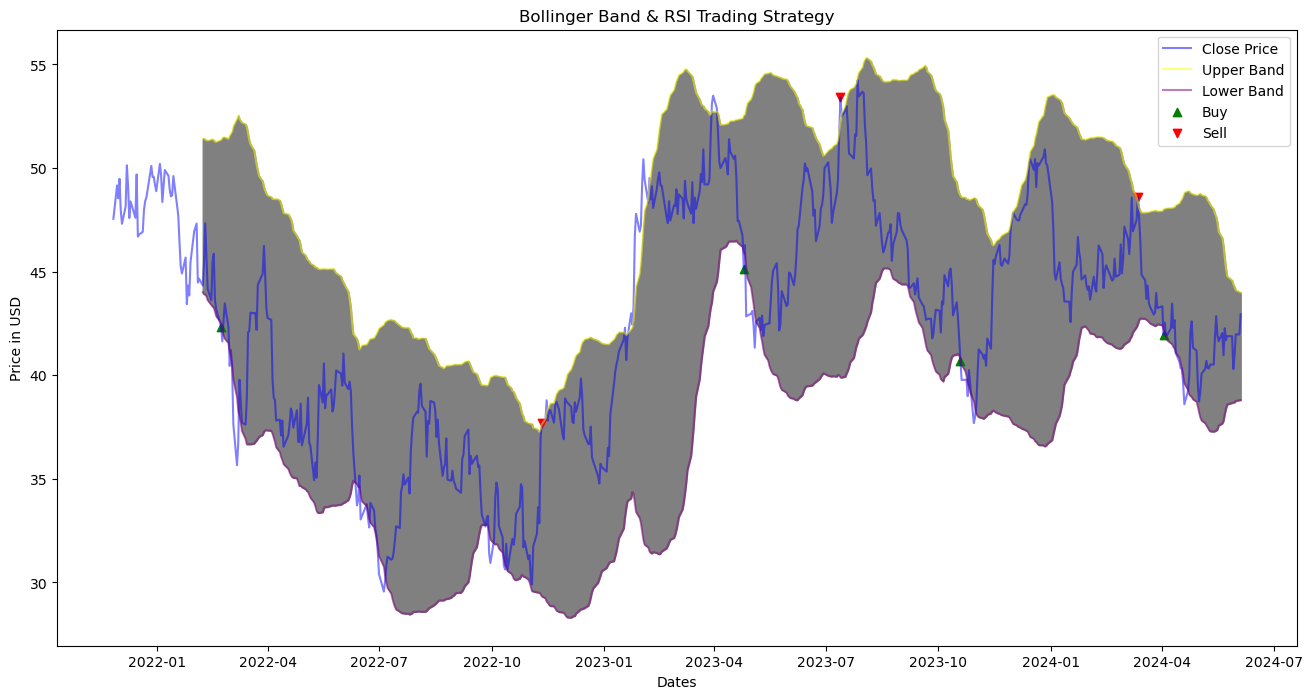

In [8]:
#Plot the close price, bollinger bands and the trading signals (buy and sell signals)
fig, ax = plt.subplots(figsize=(16,8))
plt.title('Bollinger Band & RSI Trading Strategy')
plt.ylabel('Price in USD')
plt.xlabel('Dates')
ax.plot(data['Close'], label= 'Close Price', alpha = 0.5, color='blue')
ax.plot(data['UpperBand'], label= 'Upper Band', alpha = 0.5, color='yellow')
ax.plot(data['LowerBand'], label= 'Lower Band', alpha = 0.5, color='purple')
ax.fill_between(data.index, data['UpperBand'], data['LowerBand'], color='grey')
ax.scatter(data.index, data['buy'], label="Buy", alpha=1, marker='^', color='green')
ax.scatter(data.index, data['sell'], label="Sell", alpha=1, marker='v', color='red')



plt.legend()
plt.show()

## OUTLIERS

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# Liste des symboles des actions à télécharger

symbols = [action]
#symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'BNP.PA', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD']

# Télécharger les données pour chaque action et stocker les données dans un dictionnaire
data = {}
for symbol in symbols:
    data[symbol] = yf.download(symbol, start=startdate, end=dt.datetime.today().strftime('%Y-%m-%d'))['Adj Close']

# Convertir le dictionnaire de données en DataFrame
df = pd.DataFrame(data)

# Calculer les rendements pour chaque action
returns = df.pct_change()

# Calculer la moyenne mobile et l'écart-type mobile pour chaque action
rolling_mean = returns.rolling(window=21).mean()
rolling_std = returns.rolling(window=21).std()

# Déterminer les seuils pour les valeurs aberrantes pour chaque action
N_SIGMAS = 3
upper_threshold = rolling_mean + N_SIGMAS * rolling_std
lower_threshold = rolling_mean - N_SIGMAS * rolling_std

''''
if len(symbols) == 1 :
    fig, ax = plt.subplots(figsize=(15, 5))
    #axes = axes.flatten()
    ax.plot(returns.index, returns[symbol], label=symbol)
    ax.plot(rolling_mean.index, rolling_mean[symbol], label='Rolling Mean', color='red')
    ax.fill_between(rolling_std.index, lower_threshold[symbol], upper_threshold[symbol], color='gray', alpha=0.5, label='Outlier Region')
    ax.set_title(f"{symbol} Stock Returns")
    ax.legend()
    ax.grid(True)
    
    # Plot des rendements pour chaque action
else :
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    axes = axes.flatten()
    for i, symbol in enumerate(symbols):
        ax = axes[i]
        ax.plot(returns.index, returns[symbol], label=symbol)
        ax.plot(rolling_mean.index, rolling_mean[symbol], label='Rolling Mean', color='red')
        ax.fill_between(rolling_std.index, lower_threshold[symbol], upper_threshold[symbol], color='gray', alpha=0.5, label='Outlier Region')
        ax.set_title(f"{symbol} Stock Returns")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()
'''

[*********************100%%**********************]  1 of 1 completed


'\'\nif len(symbols) == 1 :\n    fig, ax = plt.subplots(figsize=(15, 5))\n    #axes = axes.flatten()\n    ax.plot(returns.index, returns[symbol], label=symbol)\n    ax.plot(rolling_mean.index, rolling_mean[symbol], label=\'Rolling Mean\', color=\'red\')\n    ax.fill_between(rolling_std.index, lower_threshold[symbol], upper_threshold[symbol], color=\'gray\', alpha=0.5, label=\'Outlier Region\')\n    ax.set_title(f"{symbol} Stock Returns")\n    ax.legend()\n    ax.grid(True)\n    \n    # Plot des rendements pour chaque action\nelse :\n    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))\n    axes = axes.flatten()\n    for i, symbol in enumerate(symbols):\n        ax = axes[i]\n        ax.plot(returns.index, returns[symbol], label=symbol)\n        ax.plot(rolling_mean.index, rolling_mean[symbol], label=\'Rolling Mean\', color=\'red\')\n        ax.fill_between(rolling_std.index, lower_threshold[symbol], upper_threshold[symbol], color=\'gray\', alpha=0.5, label=\'Outlier Region\

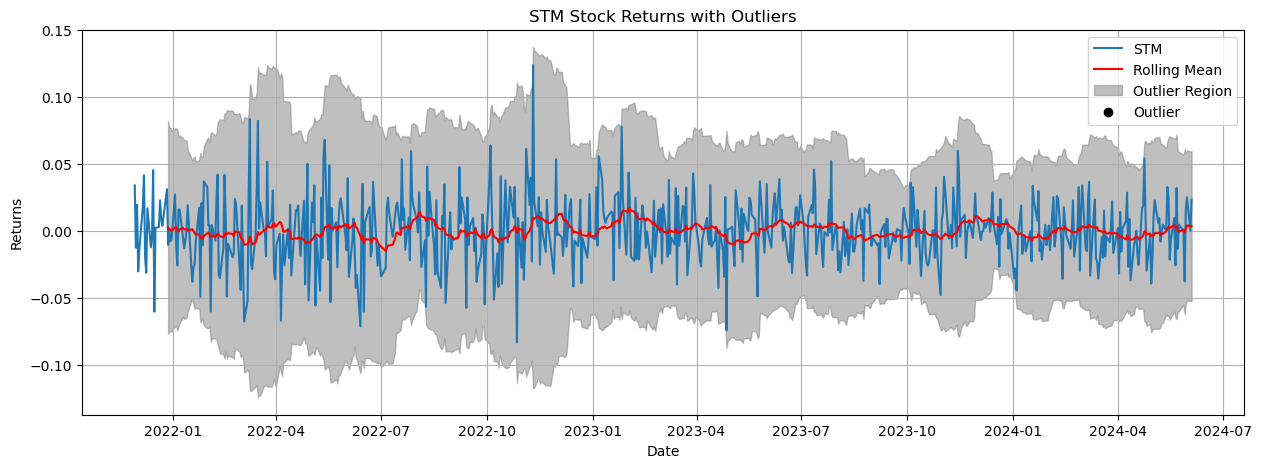

Series([], Name: STM, dtype: object)

In [10]:
# Créer un DataFrame vide pour stocker les dates des valeurs aberrantes
outliers_dates = pd.DataFrame(columns=symbols)
# Parcourir chaque action
for symbol in symbols:
    # Parcourir chaque date dans l'indice des rendements
    for date in returns.index:
        # Vérifier si la valeur du rendement est une valeur aberrante
        if (returns.loc[date, symbol] > upper_threshold.loc[date, symbol]) or \
           (returns.loc[date, symbol] < lower_threshold.loc[date, symbol]):
            # Si c'est une valeur aberrante, ajouter la date au DataFrame des valeurs aberrantes
            if date not in outliers_dates.index:
                outliers_dates.loc[date] = np.nan
            outliers_dates.loc[date, symbol] = returns.loc[date, symbol]

# Afficher le DataFrame des dates des valeurs aberrantes
#outliers_dates["AAPL"]

# Action spécifique pour laquelle vous souhaitez détecter les valeurs aberrantes
symbol = action

# Plot des rendements pour l'action spécifique
plt.figure(figsize=(15, 5))
plt.plot(returns.index, returns[symbol], label=symbol)
plt.plot(rolling_mean.index, rolling_mean[symbol], label='Rolling Mean', color='red')
plt.fill_between(rolling_std.index, lower_threshold[symbol], upper_threshold[symbol], color='gray', alpha=0.5, label='Outlier Region')

# Identifier les points de valeurs aberrantes et les marquer sur le graphique
outliers_dates_modif = outliers_dates.reset_index()
rows_without_missing_values = outliers_dates_modif[[symbol,'index']].dropna(how='all')
plt.scatter(rows_without_missing_values['index'],rows_without_missing_values[symbol], color='black', marker='o', label='Outlier')

plt.title(f"{symbol} Stock Returns with Outliers")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()
outliers_dates[action]